# Predicting Best Picture Winners & Nominees
*An Analysis by Sean Osier*

## Regression

In [6]:
# Import Dependencies
import pickle
import random
from patsy import dmatrices
from patsy import dmatrix
import statsmodels.api as sm
import statsmodels.formula.api as smf

import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.options.display.mpl_style = 'default'

import numpy as np

# For display
import pprint
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
# Pickling functions
def pickle_it(data, filename, python_version=3):
    """
    In:
    data = the data you want to pickle (save)
    filename = file name where you want to save the data
    python_version = the python version where you will be opening the pickle file
    
    Out:
    Saves a pickle file with your data to to the filename you specify
    """
    with open(filename, "wb") as picklefile:
        pickle.dump(data, picklefile, protocol=python_version)

def load_pickle(filename):
    """
    In:
    filename = name of the pickle file you want to open (e.g "my_pickle.pkl")
    
    Out:
    Opens and returns the content of the picklefile to a variable of your choice
    """
    with open(filename, "rb") as picklefile: 
        return pickle.load(picklefile)

In [8]:
# Load the data to be regressed
to_regress_raw = load_pickle("df_for_regression.pkl")

In [9]:
def get_random_years_from_range(years, years_to_pick):
    """
    In:
    year = list of years in your data set
    years_to_pick = number of year you want to randomly select (without duplication)
    
    Out:
    Prints your randomly selected years
    """
    test_years = random.sample(years, years_to_pick)
    print(test_years)

# Select which years will be for the test data, the rest will be for the training data
years = range(1990, 2015)
# get_random_years_from_range(range(1990, 2015), 5)  # Returned the below:
test_years = [1993, 2001, 2012, 2004, 2005]
train_years = list(set(years) - set(test_years))
test_years = [str(year) for year in test_years]
train_years = [str(year) for year in train_years]

In [10]:
# Split full data into the test and training sets
test_criterion = to_regress_raw["status_year"].map(lambda x: x in test_years)
train_criterion = to_regress_raw["status_year"].map(lambda x: x in train_years)

to_test_raw = to_regress_raw[test_criterion]
to_train_raw = to_regress_raw[train_criterion]

In [11]:
def oversample_nominees_and_winners(df, factor):
    """
    In:
    df = Pandas dataframe of your training data
    factor = the factor by which you want to scale the number of Best Picture nominees / winners in the data
    
    Out:
    df = Pandas dataframe of your training data now oversampled for Best Picture nominees / winners
    """
    nominees_and_winners = df[df["status_score"] > 0]
    
    for i in range(factor-1):
        df = pd.concat([df, nominees_and_winners])
    
    return df

to_train_oversample = oversample_nominees_and_winners(to_train_raw, 5)

In [12]:
def get_patsy_string(for_regression_raw_data):
    """
    In:
    for_regresssion_raw_data = Pandas dataframe of your training data (oversampled if needed)
    
    Out:
    patsy_string = Patsy regression formula string to feed into regression model
    """
    columns = list(for_regression_raw_data.columns.values)
    x_columns = columns[1:4] + columns[5:9] + columns[10:]  # Exclude unneeded columns
    
    # Start intially with adding in all possible features
    x_string = ""
    for column in x_columns:
        x_string += column + " + "
    x_string = x_string[:-2]
    
    patsy_string = "status_score ~ " + x_string
    
    """Add quadratics where it makes sense (comment out those you don't want)"""
    patsy_string = patsy_string.replace("user_rating_short", "np.power(user_rating_short, 2) + user_rating_short")
    # patsy_string = patsy_string.replace("runtime", "np.power(runtime, 2) + runtime")
    patsy_string = patsy_string.replace("critic_rating", "np.power(critic_rating, 2) + critic_rating")
    # patsy_string = patsy_string.replace("aspect_ratio", "np.power(aspect_ratio, 2) + aspect_ratio")
    patsy_string = patsy_string.replace("release_month", "np.power(release_month, 2) + release_month")
    # patsy_string = patsy_string.replace("release_day_in_year", "np.power(release_day_in_year, 2) + release_day_in_year")
    # patsy_string = patsy_string.replace("budget_USD_real", "np.power(budget_USD_real, 2) + budget_USD_real")
    # patsy_string = patsy_string.replace("opening_weekend_gross_USD_real", \
    #                      "np.power(opening_weekend_gross_USD_real, 2) + opening_weekend_gross_USD_real")
    
    """Remove feature / parameters you don't want (comment out those you actually to keep)"""
    patsy_string = patsy_string.replace("runtime", "")
    # patsy_string = patsy_string.replace(" + critic_rating", "")
    patsy_string = patsy_string.replace(" + pg_rating","")
    patsy_string = patsy_string.replace(" + aspect_ratio","")
    patsy_string = patsy_string.replace(" + release_day_in_year","")
    patsy_string = patsy_string.replace(" + budget_USD_real","")
    patsy_string = patsy_string.replace(" + opening_weekend_gross_USD_real","")
    
    # Directors to remove
    directors_to_remove = ['director_david_fincher', 'director_stanley_kubrick', 'director_ridley_scott', 
                           'director_woody_allen', 'director_paul_thomas_anderson', 'director_akira_kurosawa', 
                           'director_sergio_leone', 'director_charlie_chaplin', 'director_ingmar_bergman', 
                           'director_michael_mann', 'director_jean_luc_godard', 'director_george_lucas', 
                           'director_andrei_tarkovsky', 'director_sidney_lumet', 'director_elia_kazan', 
                           'director_werner_herzog', 'director_brian_de_palma', 'director_spike_jonze', 
                           'director_darren_aronofsky']
    for director in directors_to_remove:
        patsy_string = patsy_string.replace(" + " + director,"")
    
    # Stars to remove
    stars_to_remove = ['starring_will_smith', 'starring_christian_bale', 'starring_robert_de_niro', 
                       'starring_morgan_freeman', 'starring_clint_eastwood', 'starring_matt_damon', 
                       'starring_dustin_hoffman', 'starring_marlon_brando', 'starring_harrison_ford', 
                       'starring_shah_rukh_khan', 'starring_gary_oldman', 'starring_laurence_olivier', 
                       'starring_bruce_willis', 'starring_sean_connery', 'starring_samuel_l_jackson', 
                       'starring_mark_wahlberg', 'starring_robert_duvall', 'starring_nicolas_cage', 
                       'starring_salman_khan', 'starring_amitabh_bachchan', 'starring_adam_sandler', 
                       'starring_aamir_khan', 'starring_natalie_portman', 'starring_angelina_jolie', 
                       'starring_charlize_theron', 'starring_nicole_kidman', 'starring_meryl_streep', 
                       'starring_jennifer_aniston', 'starring_anne_hathaway', 'starring_jessica_alba', 
                       'starring_megan_fox', 'starring_audrey_hepburn', 'starring_julianne_moore', 
                       'starring_julia_roberts', 'starring_amanda_seyfried', 'starring_kristen_stewart', 
                       'starring_marilyn_monroe', 'starring_ingrid_bergman', 'starring_kate_beckinsale', 
                       'starring_sophia_loren', 'starring_olivia_wilde', 'starring_marion_cotillard', 
                       'starring_bette_davis', 'starring_zooey_deschanel', 'starring_reese_witherspoon', 
                       'starring_emily_blunt', 'starring_cameron_diaz', 'starring_olivia_de_havilland', 
                       'starring_michelle_pfeiffer', 'starring_vivien_leigh', 'starring_halle_berry', 
                       'starring_jane_fonda', 'starring_amber_heard']
    for star in stars_to_remove:
        patsy_string = patsy_string.replace(" + " + star,"")
    
    
    # Genres to remove
    genres_to_remove = ['genre_action', 'genre_adventure', 'genre_comedy', 'genre_drama', 'genre_family', 
                        'genre_fantasy', 'genre_horror', 'genre_musical', 'genre_sport']
    for genre in genres_to_remove:
        patsy_string = patsy_string.replace(" + " + genre,"")
    
    # Writers to remove
    writers_to_remove = ['writer_woody_allen', 'writer_stephen_king', 'writer_quentin_tarantino', 
                         'writer_truman_capote', 'writer_stanley_kubrick', 'writer_william_goldman', 
                         'writer_rob_reiner', 'writer_leonardo_dicaprio', 'writer_billy_wilder', 
                         'writer_will_ferrell', 'writer_jane_campion', 'writer_francis_ford_coppola', 
                         'writer_sam_raimi', 'writer_wes_craven', 'writer_hal_hartley', 'writer_paul_thomas_anderson',
                         'writer_ridley_scott', 'writer_sidney_lumet', 'writer_alan_rudolph', 'writer_steve_martin', 
                         'writer_peter_jackson', 'writer_john_carpenter', 'writer_ingmar_bergman', 
                         'writer_stephen_frears', 'writer_william_s_burroughs', 'writer_seth_rogen', 
                         'writer_terry_rossio', 'writer_walt_disney', 'writer_martin_scorsese', 
                         'writer_alfred_hitchcock', 'writer_noah_baumbach', 'writer_robert_altman', 
                         'writer_peter_benchley', 'writer_brian_helgeland', 'writer_johnny_depp']
    for writer in writers_to_remove:
        patsy_string = patsy_string.replace(" + " + writer,"")
    
    # Languages to remove:
    countries_to_remove = ['country_poland', 'country_austria', 'country_iran', 'country_turkey', 'country_sweden', 
                           'country_belgium', 'country_brazil', 'country_netherlands', 'country_australia', 
                           'country_china', 'country_south_korea', 'country_argentina', 'country_russia', 
                           'country_mexico', 'country_hong_kong', 'country_philippines', 'country_spain', 
                           'country_italy', 'country_germany', 'country_canada', 'country_uk', 'country_france', 
                           'country_japan', 'country_india']
    for country in countries_to_remove:
        patsy_string = patsy_string.replace(" + " + country,"")
    
    # Languages to remove:
    languages_to_remove = ['language_indonesian', 'language_bengali', 'language_polish', 'language_swedish', 
                           'language_dutch', 'language_persian', 'language_turkish', 'language_tamil', 
                           'language_arabic', 'language_portuguese', 'language_telugu', 'language_malayalam', 
                           'language_korean', 'language_cantonese', 'language_mandarin', 'language_tagalog', 
                           'language_filipino', 'language_russian', 'language_italian', 'language_german', 
                           'language_hindi', 'language_french', 'language_japanese', 'language_spanish']
    for language in languages_to_remove:
        patsy_string = patsy_string.replace(" + " + language,"")
    
    # Colors to remove:
    colors_to_remove = ['color_color', 'color_black_and_white']
    for color in colors_to_remove:
        patsy_string = patsy_string.replace(" + " + color,"")
    
    # Final feature sweep:
    features_to_remove = ['director_steven_spielberg', 'director_david_lynch', 'director_tony_tarantino', 
                          'director_alejandro_gonzález_iñárritu', 'director_david_lean', 'director_alfonso_cuarón', 
                          'starring_tom_cruise', 'starring_liam_neeson', 'starring_hugh_jackman', 
                          'starring_humphrey_bogart', 'starring_emma_watson', 'starring_penélope_cruz', 
                          'starring_rachel_mcadams', 'starring_helen_mirren', 'starring_sigourney_weaver', 
                          'genre_history', 'genre_mystery', 'genre_sci_fi', 'writer_steven_spielberg', 
                          'writer_guillermo_del_toro', 'writer_michael_mann', 'director_oliver_stone', 
                          'starring_scarlett_johansson', 'genre_thriller', 'director_alfred_hitchcock', 
                          'director_orson_welles', 'director_william_wyler', 'director_john_ford', 
                          'director_federico_fellini', 'director_miloš_forman', 'director_frank_capra', 
                          'starring_katharine_hepburn', 'starring_robert_downey_jr', 'starring_jennifer_lawrence', 
                          'writer_christopher_nolan', 'writer_david_cronenberg', 'writer_roman_polanski', 
                          'director_christopher_nolan', 'director_roman_polanski', 'director_david_cronenberg', 
                          'starring_heath_ledger', 'starring_robin_williams', 'starring_grace_kelly', 
                          'director_hayao_miyazaki', 'starring_johnny_depp', 'director_wes_anderson', 
                          'director_steven_soderbergh', 'starring_george_clooney', 'starring_michael_caine', 
                          'starring_edward_norton', 'starring_emma_stone', 'writer_charlie_kaufman', 
                          'writer_wes_anderson', 'starring_jeff_bridges', 'genre_crime', 'writer_owen_wilson', 
                          'director_francis_ford_coppola', 'starring_kevin_spacey', 'starring_ryan_gosling', 
                          'starring_keanu_reeves', 'starring_kate_winslet', 'starring_naomi_watts', 'genre_music', 
                          'writer_david_mamet']
    for feature in features_to_remove:
        patsy_string = patsy_string.replace(" + " + feature,"")
    
    return patsy_string

In [13]:
def run_linear_regression(data, patsy_string):
    """
    In:
    data = Pandas dataframe of your training data (oversampled if needed)
    patsy_string = Patsy regression formula string specifying the features of the regression model
    
    Out:
    Returns linear regression model fit to your training data using the features specified
    """
    return smf.ols(formula=patsy_string, data=data).fit()

In [14]:
def get_Y_Xs_for_testing(to_test_raw):
    """
    In: 
    to_test_raw = Pandas dataframe of your test data
    
    Out:
    Tuple of y, X where:
        y = The dependent / to be predicted component of your test data
        X = The indepdent variables / features of your data, used to predict y
    """
    patsy_string = get_patsy_string(to_test_raw)
    y, X = dmatrices(patsy_string, data=to_test_raw, return_type='dataframe')
    return y, X

In [15]:
def test_regression(fit_model, test_data):
    """
    In:
    fit_model = The linear regression model you would like to test
    test_data = Pandas dataframe of your test data
    
    Out:
    Tuple of result, true_positives, false_positives, net where:
        result = percentage of correct guesses by your model
        true_positives = the number of correctly identified Best Picture nominees / winners
        false_positives = the number of falsely identified Best Picture nominees / winners
        net = true positives adjusted for the number of false positives
    """
    test_Y, test_X = get_Y_Xs_for_testing(test_data)
    
    # Make predictions
    predictions = [sum([coef * x for coef, x in zip(fit_model.params, row)]) for row in test_X.values.tolist()]
    predictions = [y//5 if y > 0 else 0 for y in predictions]
    
    # Evaluate predictions
    result = [1 if prediction == actual[0] else 0 for prediction, actual in zip(predictions, test_Y.values.tolist())]
    result = sum(result) / len(result)  # Percentage correct
    
    # Check true / false positives
    true_positives = sum([1 for prediction, actual in zip(predictions, test_Y.values.tolist()) \
                          if (prediction == actual[0] and actual[0] > 0)])
    false_positives = sum([1 for prediction, actual in zip(predictions, test_Y.values.tolist()) \
                           if (prediction != actual[0] and prediction > 0) ])
    net = true_positives - false_positives
    
    return result, true_positives, false_positives, net

### Final Model

In [16]:
model = run_linear_regression(to_train_raw, get_patsy_string(to_train_raw))
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           status_score   R-squared:                       0.248
Model:                            OLS   Adj. R-squared:                  0.242
Method:                 Least Squares   F-statistic:                     37.83
Date:                Sun, 11 Oct 2015   Prob (F-statistic):               0.00
Time:                        21:23:28   Log-Likelihood:                -6787.6
No. Observations:                6129   AIC:                         1.368e+04
Df Residuals:                    6075   BIC:                         1.405e+04
Df Model:                          53                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------------------------
Intercept                           1.9535      0.225      8.668      0.000         1.512     2.395
num_nominees[T.>5]                  0.0587      0.019      3.017      0.003         0.021     0.097
np.power(user_rating_short, 2)      0.0580      0.007      8.540      0.000         0.045     0.071
user_rating_short                  -0.5997      0.081     -7.390      0.000        -0.759    -0.441
np.power(critic_rating, 2)          0.0004   2.82e-05     13.499      0.000         0.000     0.000
critic_rating                      -0.0340      0.003    -11.178      0.000        -0.040    -0.028
np.power(release_month, 2)          0.0041      0.001      4.447      0.000         0.002     0.006
release_month                      -0.0518      0.012     -4.224      0.000        -0.076    -0.028
director_martin_scorsese            1.8264      0.248      7.358      0.000         1.340     2.313
director_quentin_tarantino          1.1454      0.332      3.446      0.001         0.494     1.797
director_james_cameron              1.6806      0.557      3.017      0.003         0.589     2.773
director_clint_eastwood             1.0040      0.180      5.568      0.000         0.651     1.357
director_peter_jackson              1.8330      0.302      6.063      0.000         1.240     2.426
director_tim_burton                -0.6583      0.264     -2.496      0.013        -1.175    -0.141
director_joel_coen                  1.4391      0.215      6.696      0.000         1.018     1.860
director_ang_lee                    0.9702      0.279      3.471      0.001         0.422     1.518
director_terrence_malick            3.7784      0.563      6.717      0.000         2.676     4.881
director_sam_mendes                 1.5685      0.373      4.200      0.000         0.836     2.301
director_frank_darabont             2.2602      0.430      5.251      0.000         1.416     3.104
starring_leonardo_dicaprio          0.5070      0.187      2.705      0.007         0.140     0.874
starring_brad_pitt                  0.3395      0.152      2.235      0.025         0.042     0.637
starring_tom_hanks                  1.1828      0.165      7.185      0.000         0.860     1.506
starring_jack_nicholson             1.4047      0.225      6.242      0.000         0.964     1.846
starring_denzel_washington         -0.3929      0.160     -2.463      0.014        -0.706    -0.080
starring_al_pacino                  0.5387      0.174      3.089      0.002         0.197     0.881
starring_daniel_day_lewis           0.9476      0.334      2.836      0.005         0.293     1.603
starring_russell_crowe              0.9586      0.171      5.594      0.000         0.623     1.295
starring_anthony_hopkins            0.3365      0.152      2.214      0.027        

In [18]:
result, true_positives, false_positives, net = test_regression(model, to_test_raw)
print("Accuracy: " + str(result))
print("True Positives: " + str(true_positives))
print("False Positives: " + str(false_positives))
print("Net: " + str(net))

Accuracy: 0.9840484048404841
True Positives: 0
False Positives: 0
Net: 0


### Early Exploratory Plots

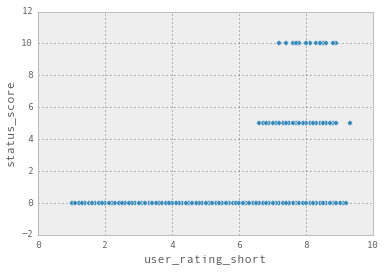

In [369]:
to_train_raw.plot(kind="scatter", x="user_rating_short", y="status_score")

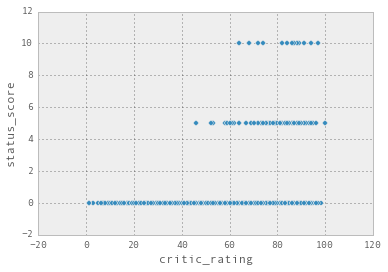

In [370]:
to_train_raw.plot(kind="scatter", x="critic_rating", y="status_score")

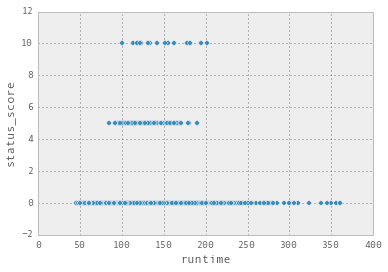

In [371]:
to_train_raw.plot(kind="scatter", x="runtime", y="status_score")

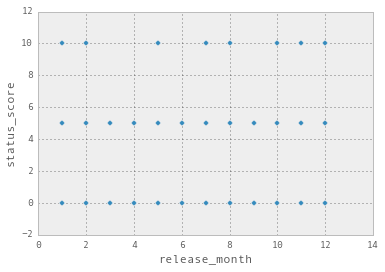

In [372]:
to_train_raw.plot(kind="scatter", x="release_month", y="status_score")

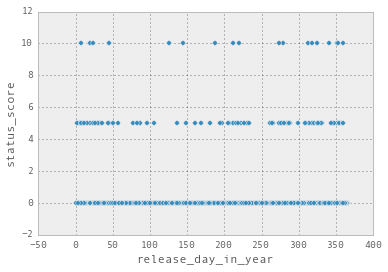

In [373]:
to_train_raw.plot(kind="scatter", x="release_day_in_year", y="status_score")

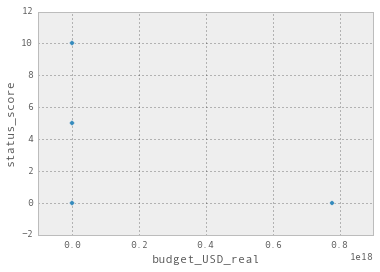

In [374]:
to_train_raw.plot(kind="scatter", x="budget_USD_real", y="status_score")

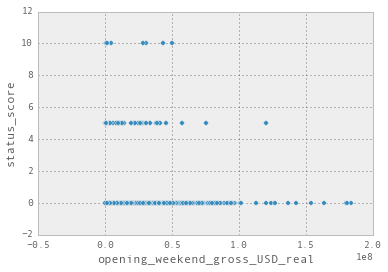

In [375]:
to_train_raw.plot(kind="scatter", x="opening_weekend_gross_USD_real", y="status_score")

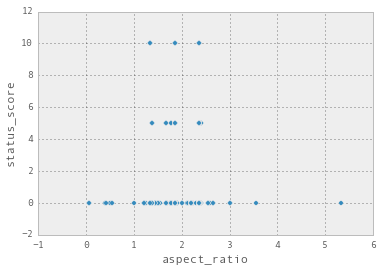

In [376]:
to_train_raw.plot(kind="scatter", x="aspect_ratio", y="status_score")

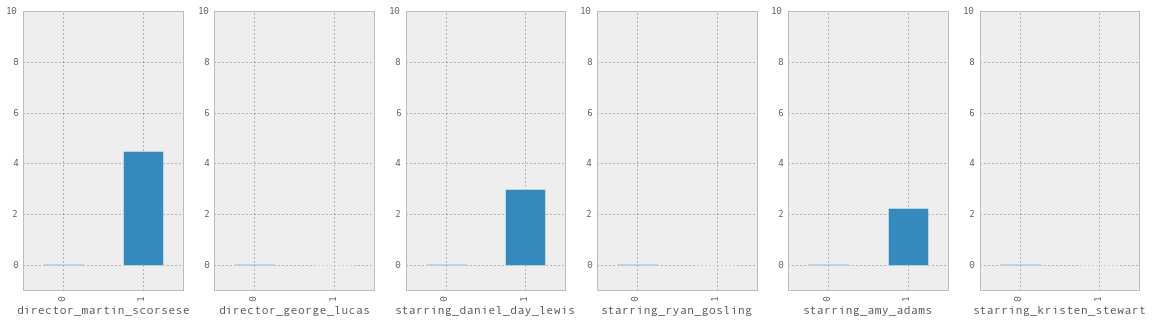

In [377]:
def plot_boolean(param, n):
    """
    In:
    param = Boolean parameter to plot
    n = Subplot number
    
    Out:
    Subplot of desired boolean parameter
    """
    grouped = to_train_raw.groupby(param)
    to_plot = grouped["status_score"].mean()
    to_plot.plot(kind="bar", ylim=(-1,10), ax=axes[n], figsize=(20, 5))
    
fig, axes = plt.subplots(nrows=1, ncols=6)
plot_boolean("director_martin_scorsese", 0)
plot_boolean("director_george_lucas", 1)
plot_boolean("starring_daniel_day_lewis", 2)
plot_boolean("starring_ryan_gosling", 3)
plot_boolean("starring_amy_adams", 4)
plot_boolean("starring_kristen_stewart", 5)